# DS-SF-23 | Codealong and Lab 13 | Natural Language Processing and Text Classification

# Codealong - Text Processing with `sklearn`

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_extraction, ensemble, cross_validation, metrics

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

The data is about sentiments on Amazon reviews.

In [3]:
reviews = []
sentiments = []

# take each line in the text file and create a separate review object for each string
# that meets the following conditions
with open(os.path.join('..', 'datasets', 'amazon-reviews.txt')) as f:
    for line in f.readlines():
#         demarcates each line based on the newline symbol between each review
        line = line.strip('\n')
#     demarcates sentiment from review content
        review, sentiment = line.split('\t')
#     designates empty sentiment strings as null (we'll drop these soon)
        sentiment = np.nan if sentiment == '' else int(sentiment)
        reviews.append(review)
        sentiments.append(sentiment)

df = pd.DataFrame({'review': reviews, 'sentiment': sentiments})

In [4]:
df.head()

,review,sentiment
0,I try not to adjust the volume setting to avoi...,NaN
1,So there is no way for me to plug it in here i...,0.0
2,"Good case, Excellent value.",1.0
3,I thought Motorola made reliable products!.,NaN
4,Battery for Motorola Razr.,NaN


In [5]:
# Drop all records where any fields are null
df.dropna(inplace = True) 

In [6]:
df.head()

,review,sentiment
1,So there is no way for me to plug it in here i...,0.0
2,"Good case, Excellent value.",1.0
5,Great for the jawbone.,1.0
10,Tied to charger for conversations lasting more...,0.0
11,The mic is great.,1.0


In [7]:
X = df.review
y = df.sentiment

## Train/test sets

In [8]:
# split data into training and test datasets (60%/40% share of data)
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y, test_size = 0.4)

In [9]:
train_X

2662                                          cool phone.
418                                I Was Hoping for More.
250     Integrated seamlessly with the Motorola RAZR p...
2012    Bluetooth does not work, phone locks up, scree...
1129    I've dropped my phone more times than I can sa...
                              ...                        
1298          I highly recommend this device to everyone!
1938                      Don't bother - go to the store.
1146    Their network coverage in Los Angeles is horri...
2633    I can hear while I'm driving in the car, and u...
1363                                 Warning - Stay away.
Name: review, dtype: object

## `CountVectorizer`

`CountVectorizer` converts a collection of text into a matrix of features.  Each row will be a sample (an article or piece of text) and each column will be a text feature (usually a count or binary feature per word).

`CountVectorizer` takes a column of text and creates a new dataset.  It generates a feature for every word in all of the pieces of text.

CAUTION: Using all of the words can be useful, but we may need to use regularization to avoid overfitting.  Otherwise, rare words may cause the model to overfit and not generalize.

(And check http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html as needed)

In [10]:
# Instantiate a new CountVectorizer

# Stopwords are non-content words.  (e.g. 'to', 'the', and 'it')
# They aren’t helpful for prediction, so we remove them.

vectorizer = feature_extraction.text.CountVectorizer(stop_words = 'english')

In [11]:
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Vectorizers are like other models in `sklearn`:
- We create a vectorizer object with the parameters of our feature space
- We fit a vectorizer to learn the vocabulary
- We transform a set of text into that feature space

Note: there is a distinction between fit and transform:
- We fit from our training set.  This is part of the model building process, so we don't look at our test set
- We transform our test set using our model fit on the training set

In [12]:
# We use `fit` to learn the vocabulary of the reviews
# Creates feature matrix, not actually training against a particular value for the response variable (DV)
vectorizer.fit(train_X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
# The bag-of-words

vectorizer.get_feature_names()

['10',
 '100',
 '11',
 '12',
 '13',
 '15',
 '15g',
 '18',
 '2160',
 '24',
 '2mp',
 '325',
 '375',
 '42',
 '45',
 '50',
 '5020',
 '510',
 '5320',
 '8125',
 '8525',
 'abhor',
 'able',
 'absolutely',
 'accept',
 'acceptable',
 'access',
 'accessable',
 'accessing',
 'accessoryone',
 'accompanied',
 'actually',
 'adapter',
 'adapters',
 'address',
 'adhesive',
 'adorable',
 'advertised',
 'advise',
 'aggravating',
 'ago',
 'alarm',
 'allot',
 'allowing',
 'allows',
 'amazed',
 'amazon',
 'angeles',
 'angle',
 'answer',
 'ant',
 'apparently',
 'appearance',
 'appears',
 'appointments',
 'area',
 'arguing',
 'armband',
 'arrival',
 'arrived',
 'ask',
 'aspect',
 'assumed',
 'atleast',
 'att',
 'attractive',
 'audio',
 'authentic',
 'auto',
 'available',
 'average',
 'avoid',
 'avoiding',
 'away',
 'awesome',
 'awful',
 'awkward',
 'awsome',
 'background',
 'bad',
 'bar',
 'barely',
 'bargain',
 'bars',
 'basically',
 'batteries',
 'battery',
 'beautiful',
 'beep',
 'beeping',
 'behing',
 'be

In [25]:
# We use `tranform` to generate the sample X word matrix - one column per feature (here, a word)
# Words not learned from the training data will be dropped when model is used on the test dataset
train_X_transformed = vectorizer.transform(train_X)
test_X_transformed = vectorizer.transform(test_X)

In [26]:
train_X_transformed

<600x1176 sparse matrix of type '<class 'numpy.int64'>'
	with 2798 stored elements in Compressed Sparse Row format>

While dense matrices store every entry in the matrix, sparse matrices only store the nonzero entries.  Sparse matrices don't have a lot of extra features, and some algorithms may not work for them so you use them when you need to work with matrices that would be too big for the computer to handle them, but they are mostly zero, so they compress easily.  You can convert from sparse matrices to dense matrices with `.todense()`

In [28]:
train_X_transformed.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

## Random Forest

We can now build a random forest model to predict "sentiment".

In [29]:
# call Random Forest model on the data object, including a (problematically low) number of decision trees to generate
model = ensemble.RandomForestClassifier(n_estimators = 5)

# return indicators of accuracy (bias and variance)
cross_validation.cross_val_score(model, train_X_transformed, train_y, scoring = 'roc_auc')

array([ 0.81162076,  0.7697579 ,  0.80771174])

In [30]:
model.fit(train_X_transformed, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
# by default, returns score in terms of GINI (p/1-p) -- (fyi, could pass an arg to measure by reduction in H (Entropy))
model.score(train_X_transformed, train_y)

0.97499999999999998

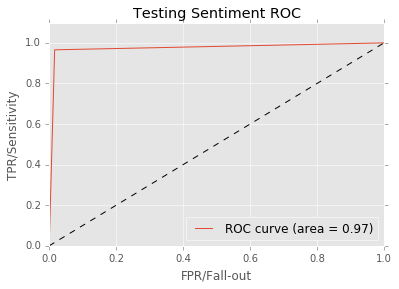

In [23]:
train_y_hat = model.predict(train_X_transformed)

fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_hat)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title('Testing Sentiment ROC')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
model.score(test_X_transformed, test_y)

In [ ]:
test_y_hat = model.predict(test_X_transformed)

fpr, tpr, thresholds = metrics.roc_curve(test_y, test_y_hat)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title('Training Sentiment ROC')
plt.legend(loc = 'lower right')
plt.show()

# Lab - TF-IDF

Directions: Redo the analysis above with `TfidfVectorizer` instead of `CountVectorizer`.  What do you get?

(Check http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html as needed)

In [ ]:
# TODO
# Use TF-IDF instead of Vectorizer